In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       #transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      transforms.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ])


In [5]:
train = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:06<00:00, 24732901.79it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
test_loader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.49139968, 0.48215841, 0.44653091), std=(0.24703223, 0.24348513, 0.26158784))
           )

In [8]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
#train_data = train.train_data
train_data = train.data/255

print('[Train]')
print(' - Numpy Shape:', train.data.shape)
print(' - Tensor Shape:', torch.tensor(train.data).size())
print(' - min:', torch.min(torch.tensor(train_data)))
print(' - max:', torch.max(torch.tensor(train_data)))
print(' - mean:', train_data.mean(axis = (0,1,2)))
print(' - std:', train_data.std(axis = (0,1,2)))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)


[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0., dtype=torch.float64)
 - max: tensor(1., dtype=torch.float64)
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
torch.Size([512, 3, 32, 32])
torch.Size([512])


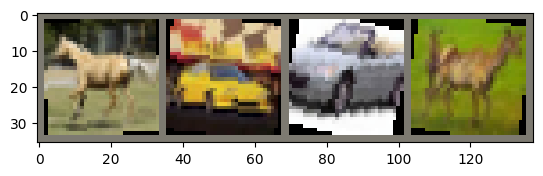

horse car   car   deer 


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    img[0] = img[0]*0.24703223 + 0.49139968
    img[1] = img[1]*0.24348513 + 0.48215841
    img[2] = img[2]*0.26158784 + 0.44653091
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        num_groups = 1 #1 for Layernorm
        # Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 5, stride=1, padding=1, bias=False),  #28>>28 | 1>>3 | 1>>1
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),
            nn.Dropout(0.1),
            nn.Conv2d(32, 64, 3, stride=1, padding=1, bias=False),#28>>28 | 3>>5 | 1>>1
            nn.ReLU(),
            nn.GroupNorm(num_groups, 64),
            nn.Dropout(0.1)

        )
        # Transition Block 1
        self.trans1 = nn.Sequential(
            nn.Conv2d(64, 16, 1, stride =1,padding=0, bias=False),  #28>>28 | 3>>3 | 1>>1
            #nn.ReLU(),
            #nn.BatchNorm2d(16),
            #nn.Dropout(0.1),
            nn.MaxPool2d(2, 2),#28>>14 | 5>>6 | 1>>2

        )
        # Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 16, 3, stride=1, padding=1, bias=False), #12>>10 | 10>>14 | 2>>2
            nn.ReLU(),
            nn.GroupNorm(num_groups, 16),
            nn.Dropout(0.1),
            nn.Conv2d(16, 16, 3, stride=1, padding=1, bias=False), #10>>8 | 14>>18 | 2>>2
            nn.ReLU(),
            nn.GroupNorm(num_groups, 16),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, 3, stride=1, padding=1, bias=False), #8>>6 | 18>>22 | 2>>2
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),
            nn.Dropout(0.1),

        )
        # Transition Block 2
        self.trans2 = nn.Sequential(
            nn.Conv2d(32, 16, 1, stride=1, bias=False),#12>>12 | 10>>10 | 2>>2
            #nn.ReLU(),
            #nn.BatchNorm2d(16),
            #nn.Dropout(0.1),
            nn.MaxPool2d(2, 2),#28>>14 | 5>>6 | 1>>2

        )

        # Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3, stride=1, padding=0, bias=False), #12>>10 | 10>>14 | 2>>2
            nn.ReLU(),
            nn.GroupNorm(num_groups, 16),
            nn.Dropout(0.1),
            nn.Conv2d(16, 32, 3, stride=1, padding=0, bias=False), #10>>8 | 14>>18 | 2>>2
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),
            nn.Dropout(0.1),
            nn.Conv2d(32, 32, 3, stride=1, padding=0, bias=False), #8>>6 | 18>>22 | 2>>2
            nn.ReLU(),
            nn.GroupNorm(num_groups, 32),
            nn.Dropout(0.1),

        )

        self.fc = nn.Sequential(
            nn.Conv2d(32, 10, 1, stride=1, padding=0, bias=False), #6>>6 | 22>>26 | 2>>2
            #nn.ReLU(),
            #nn.BatchNorm2d(1),
            #nn.Dropout(0.05),
            #nn.Linear(10, 10)

        )
        self.gap = nn.Sequential(
            #nn.AvgPool2d(kernel_size=16)
            nn.AdaptiveAvgPool2d((1, 1))
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        #x = self.norm4(x)
        #print('SIze', x.size)
        #x = x.view(-1, 3200)

        #x = x.view(x.size(0), -1)

        x = self.gap(x)
        x = self.fc(x)
        #x = self.gpool(x)
        x = x.view(-1, 10)
        #x = F.relu(self.fc1(x))
        #x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [17]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]           2,400
              ReLU-2           [-1, 32, 30, 30]               0
         GroupNorm-3           [-1, 32, 30, 30]              64
           Dropout-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 64, 30, 30]          18,432
              ReLU-6           [-1, 64, 30, 30]               0
         GroupNorm-7           [-1, 64, 30, 30]             128
           Dropout-8           [-1, 64, 30, 30]               0
            Conv2d-9           [-1, 16, 30, 30]           1,024
        MaxPool2d-10           [-1, 16, 15, 15]               0
           Conv2d-11           [-1, 16, 15, 15]           2,304
             ReLU-12           [-1, 16, 15, 15]               0
        GroupNorm-13           [-1, 16, 15, 15]              32
          Dropout-14           [-1, 16,

In [18]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [19]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
num_epochs = 20
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    train(model, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test(model, device, test_loader)

Epoch 1


Loss=1.901582956314087 Batch_id=97 Accuracy=25.72: 100%|██████████| 98/98 [00:28<00:00,  3.48it/s]



Test set: Average loss: 1.7783, Accuracy: 3460/10000 (34.60%)

Epoch 2


Loss=1.6304619312286377 Batch_id=97 Accuracy=39.31: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]



Test set: Average loss: 1.5544, Accuracy: 4363/10000 (43.63%)

Epoch 3


Loss=1.4913138151168823 Batch_id=97 Accuracy=44.72: 100%|██████████| 98/98 [00:18<00:00,  5.36it/s]



Test set: Average loss: 1.4583, Accuracy: 4762/10000 (47.62%)

Epoch 4


Loss=1.393898844718933 Batch_id=97 Accuracy=48.40: 100%|██████████| 98/98 [00:18<00:00,  5.24it/s]



Test set: Average loss: 1.3350, Accuracy: 5245/10000 (52.45%)

Epoch 5


Loss=1.3132743835449219 Batch_id=97 Accuracy=51.27: 100%|██████████| 98/98 [00:27<00:00,  3.52it/s]



Test set: Average loss: 1.2686, Accuracy: 5429/10000 (54.29%)

Epoch 6


Loss=1.212906837463379 Batch_id=97 Accuracy=53.25: 100%|██████████| 98/98 [00:28<00:00,  3.44it/s]



Test set: Average loss: 1.2153, Accuracy: 5680/10000 (56.80%)

Epoch 7


Loss=1.3144891262054443 Batch_id=97 Accuracy=55.68: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]



Test set: Average loss: 1.1877, Accuracy: 5721/10000 (57.21%)

Epoch 8


Loss=1.1750606298446655 Batch_id=97 Accuracy=57.62: 100%|██████████| 98/98 [00:18<00:00,  5.25it/s]



Test set: Average loss: 1.1564, Accuracy: 5841/10000 (58.41%)

Epoch 9


Loss=1.0496323108673096 Batch_id=97 Accuracy=58.91: 100%|██████████| 98/98 [00:20<00:00,  4.77it/s]



Test set: Average loss: 1.0787, Accuracy: 6162/10000 (61.62%)

Epoch 10


Loss=1.1389977931976318 Batch_id=97 Accuracy=60.34: 100%|██████████| 98/98 [00:18<00:00,  5.31it/s]



Test set: Average loss: 1.0743, Accuracy: 6233/10000 (62.33%)

Epoch 11


Loss=1.0963902473449707 Batch_id=97 Accuracy=61.25: 100%|██████████| 98/98 [00:18<00:00,  5.19it/s]



Test set: Average loss: 1.0892, Accuracy: 6158/10000 (61.58%)

Epoch 12


Loss=1.1273466348648071 Batch_id=97 Accuracy=62.47: 100%|██████████| 98/98 [00:19<00:00,  5.11it/s]



Test set: Average loss: 0.9781, Accuracy: 6570/10000 (65.70%)

Epoch 13


Loss=1.0132215023040771 Batch_id=97 Accuracy=63.48: 100%|██████████| 98/98 [00:18<00:00,  5.19it/s]



Test set: Average loss: 0.9747, Accuracy: 6536/10000 (65.36%)

Epoch 14


Loss=1.0354831218719482 Batch_id=97 Accuracy=64.41: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]



Test set: Average loss: 0.9615, Accuracy: 6638/10000 (66.38%)

Epoch 15


Loss=0.9127821326255798 Batch_id=97 Accuracy=65.07: 100%|██████████| 98/98 [00:18<00:00,  5.39it/s]



Test set: Average loss: 0.9332, Accuracy: 6771/10000 (67.71%)

Epoch 16


Loss=0.8770687580108643 Batch_id=97 Accuracy=65.53: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]



Test set: Average loss: 0.9384, Accuracy: 6714/10000 (67.14%)

Epoch 17


Loss=1.0185884237289429 Batch_id=97 Accuracy=66.44: 100%|██████████| 98/98 [00:18<00:00,  5.16it/s]



Test set: Average loss: 0.8944, Accuracy: 6885/10000 (68.85%)

Epoch 18


Loss=0.933948814868927 Batch_id=97 Accuracy=67.45: 100%|██████████| 98/98 [00:18<00:00,  5.27it/s]



Test set: Average loss: 0.8943, Accuracy: 6875/10000 (68.75%)

Epoch 19


Loss=0.9129141569137573 Batch_id=97 Accuracy=67.24: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]



Test set: Average loss: 0.9366, Accuracy: 6703/10000 (67.03%)

Epoch 20


Loss=0.9227136969566345 Batch_id=97 Accuracy=67.89: 100%|██████████| 98/98 [00:18<00:00,  5.31it/s]



Test set: Average loss: 0.8884, Accuracy: 6899/10000 (68.99%)



Text(0.5, 1.0, 'Test Accuracy')

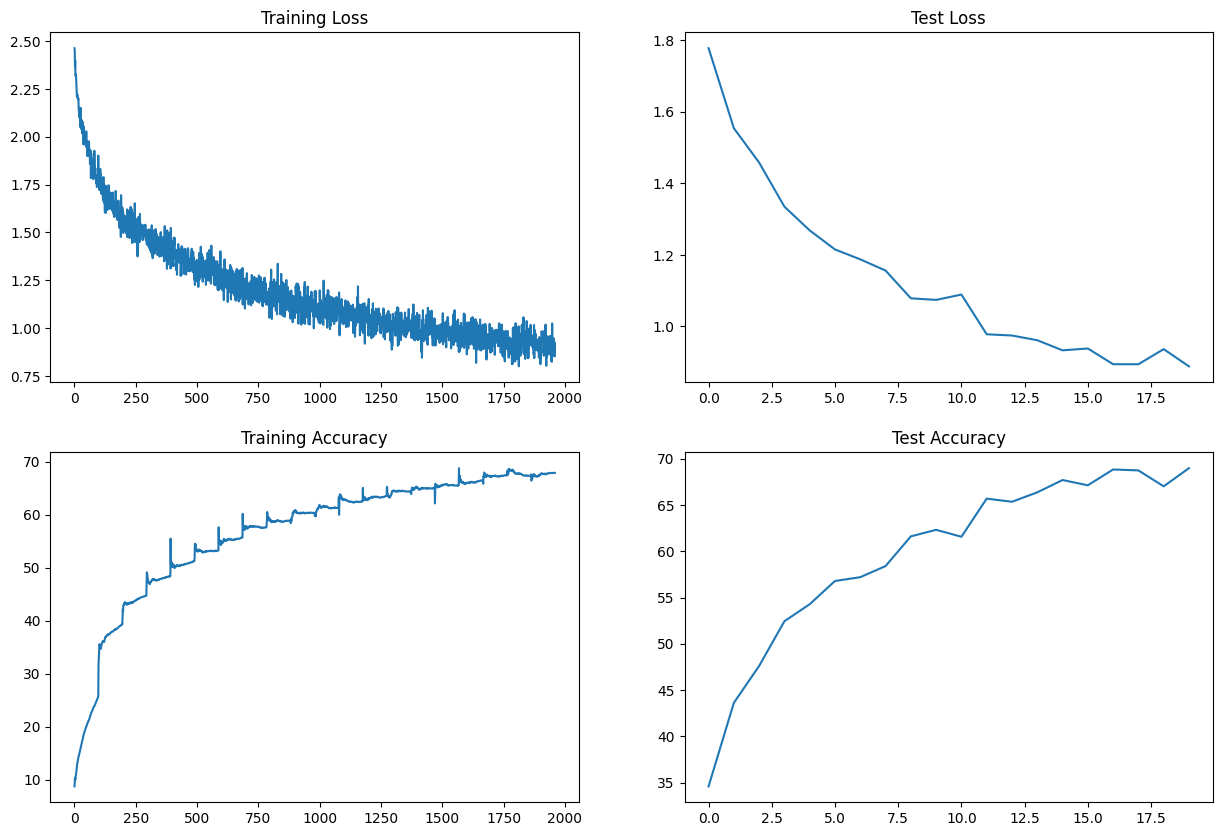

In [21]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [22]:
model.eval()
test_loss = 0
correct = 0
i =0
LN_misclassified_dict = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        #print('pred',pred)
        #print('target', target.view_as(pred))
        #print('test eq', pred.eq(target.view_as(pred)).sum().item())
        #print('test 1', pred.eq(target.view_as(pred)))
        #print('test 2', pred.eq(target.view_as(pred)).sum())
        #print('test 3', pred.eq(target.view_as(pred)).sum().item())
        #print('test 4', pred.shape)
        #print('test target', target.shape)
        #print('test data', data.shape)
        t = pred.eq(target.view_as(pred)).view(-1, target.size(0))
        t = t.cpu().numpy().reshape(-1)
        for ind,val in enumerate(t):
          if not val :
            temp_dict = {}
            temp_dict['data'] = data[ind].cpu().numpy()
            temp_dict['target'] = target[ind]
            temp_dict['pred'] = pred[ind]
            LN_misclassified_dict.append(temp_dict)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [23]:
LN_misclassified_dict = LN_misclassified_dict[::-1]

In [25]:
def imshow1(img):
    # unnormalize
    img[0] = img[0]*0.24703223 + 0.49139968
    img[1] = img[1]*0.24348513 + 0.48215841
    img[2] = img[2]*0.26158784 + 0.44653091
    #img = img*255
    #img = img / 2 + 0.5
    #npimg = img.numpy()
    #plt.imshow(np.transpose(img, (1, 2, 0)))
    #plt.show()
    return np.transpose(img, (1, 2, 0))

In [ ]:
imshow1(LN_misclassified_dict[3]['data'])

Text(0.5, 1.0, 'plane')

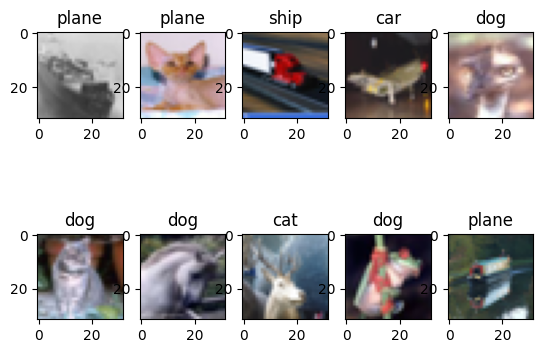

In [26]:
import random
f, axarr = plt.subplots(2,5)
i = random.randint(0,len(LN_misclassified_dict))
axarr[0,0].imshow(imshow1(LN_misclassified_dict[i]['data']))
axarr[0,0].set_title(classes[LN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(LN_misclassified_dict))
axarr[0,1].imshow(imshow1(LN_misclassified_dict[i]['data']))
axarr[0,1].set_title(classes[LN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(LN_misclassified_dict))
axarr[0,2].imshow(imshow1(LN_misclassified_dict[i]['data']))
axarr[0,2].set_title(classes[LN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(LN_misclassified_dict))
axarr[0,3].imshow(imshow1(LN_misclassified_dict[i]['data']))
axarr[0,3].set_title(classes[LN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(LN_misclassified_dict))
axarr[0,4].imshow(imshow1(LN_misclassified_dict[i]['data']))
axarr[0,4].set_title(classes[LN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(LN_misclassified_dict))
axarr[1,0].imshow(imshow1(LN_misclassified_dict[i]['data']))
axarr[1,0].set_title(classes[LN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(LN_misclassified_dict))
axarr[1,1].imshow(imshow1(LN_misclassified_dict[i]['data']))
axarr[1,1].set_title(classes[LN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(LN_misclassified_dict))
axarr[1,2].imshow(imshow1(LN_misclassified_dict[i]['data']))
axarr[1,2].set_title(classes[LN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(LN_misclassified_dict))
axarr[1,3].imshow(imshow1(LN_misclassified_dict[i]['data']))
axarr[1,3].set_title(classes[LN_misclassified_dict[i]['pred']], fontsize=12)
i = random.randint(0,len(LN_misclassified_dict))
axarr[1,4].imshow(imshow1(LN_misclassified_dict[i]['data']))
axarr[1,4].set_title(classes[LN_misclassified_dict[i]['pred']], fontsize=12)